# Cox-Time
In this notebook we will train the [Cox-Time method](http://jmlr.org/papers/volume20/18-424/18-424.pdf). The main benefit Cox-Time (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
import torchtuples as tt

from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [21]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Conjunto de datos
Cargamos el conjunto de datos preprocesados y lo dividimos en test y validation

In [22]:
df = pd.read_csv('./../datasets/arhv_prepro_5.0.csv')
df

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,F36,F37,F38,F39,F40,F41,F42,F43,event,time
0,0,0,1.0,1.0,0,0,0,0,0,0,...,0.104192,0.023926,1.305501,0.260649,0.122838,-0.060748,1.227461,-0.033476,0,21.0
1,0,40,2.0,1.0,1,0,0,2,0,0,...,0.187715,0.151417,0.626269,0.132299,0.251000,0.013268,-0.292335,-0.006962,0,22.0
2,0,18,2.0,1.0,0,0,0,0,0,0,...,0.385539,0.336895,1.361841,0.594791,0.949946,-0.011401,-1.925450,-0.017829,0,22.0
3,19,7,0.0,1.0,0,0,0,0,0,0,...,0.596548,0.407431,1.593357,0.224175,0.643866,0.031109,-0.442274,-0.027099,1,14.0
4,19,0,2.0,1.0,0,0,0,0,0,0,...,0.123080,0.117009,0.793149,0.381961,0.942754,0.003329,-0.745527,-0.009753,1,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6376,18,16,1.0,0.0,0,0,0,1,0,0,...,0.190463,0.168681,1.046977,0.091520,0.093166,-0.013568,-2.566817,-0.022228,1,9.0
6377,13,13,3.0,0.0,0,0,0,1,0,0,...,0.298466,0.133987,0.314466,0.145075,0.717814,0.065671,-0.155346,-0.015047,1,12.0
6378,11,11,1.0,0.0,0,0,0,1,0,0,...,0.124445,0.065487,0.977181,0.165864,0.017639,-0.008573,-1.151375,-0.043251,1,9.0
6379,9,5,1.0,0.0,0,0,0,0,0,0,...,0.000000,0.000000,0.522243,0.152878,-0.100963,-0.010897,-1.877954,-0.019716,1,15.0


In [23]:
df_train = df
df_test = df.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

print(f"Train dataset stats: {df_train.shape}, Validation datasets stats: {df_val.shape}, Test dataset stats: {df_test.shape}")

Train dataset stats: (4084, 45), Validation datasets stats: (1021, 45), Test dataset stats: (1276, 45)


In [24]:
df_train.head()

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,F36,F37,F38,F39,F40,F41,F42,F43,event,time
0,0,0,1.0,1.0,0,0,0,0,0,0,...,0.104192,0.023926,1.305501,0.260649,0.122838,-0.060748,1.227461,-0.033476,0,21.0
1,0,40,2.0,1.0,1,0,0,2,0,0,...,0.187715,0.151417,0.626269,0.132299,0.251000,0.013268,-0.292335,-0.006962,0,22.0
2,0,18,2.0,1.0,0,0,0,0,0,0,...,0.385539,0.336895,1.361841,0.594791,0.949946,-0.011401,-1.925450,-0.017829,0,22.0
3,19,7,0.0,1.0,0,0,0,0,0,0,...,0.596548,0.407431,1.593357,0.224175,0.643866,0.031109,-0.442274,-0.027099,1,14.0
9,17,0,1.0,1.0,0,0,0,1,0,0,...,0.184629,0.098159,0.508884,0.184394,-0.056303,-0.022431,-3.495778,-0.031419,1,11.0


## Feature transforms

Tenemos un total de 43 covariables, y adicionalmente la duracion y el indicador del evento.


In [25]:
from sklearn.compose import ColumnTransformer
cols = df_train.columns.tolist()
cols.remove('event')
cols.remove('time')

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), cols)],
    remainder='passthrough',
    verbose_feature_names_out=False
)

x_train = preprocessor.fit_transform(df_train).astype('float32')
x_val = preprocessor.transform(df_val).astype('float32')
x_test = preprocessor.transform(df_test).astype('float32')

In [26]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['time'].values.astype("float32"), df['event'].values.astype("float32"))
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)
val.shapes()

((1021, 45), ((1021,), (1021,)))

With TupleTree (the results of tt.tuplefy) we can easily repeat the validation dataset multiple times. This will be useful for reduce the variance of the validation loss, as the validation loss of CoxTime is not deterministic.

In [27]:
val.repeat(2).cat().shapes()

((2042, 45), ((2042,), (2042,)))

## Neural net
We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. The net required by `CoxTime` is slightly different than most of the other methods as it also take time and an additional input argument. We have therefore crated the `MLPVanillaCoxTime` class that is a suitable version of `tt.practical.MLPVanilla`. This class also removes the options for setting out_features and output_bias as they should be 1 and False, respectively.
To see the code for the networks call `MLPVanillaCoxTime`.

In [28]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)
net.eval()

MLPVanillaCoxTime(
  (net): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=46, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (2): Linear(in_features=32, out_features=1, bias=False)
    )
  )
)

## Training the model
To train the model we need to define an optimizer. You can choose any `torch.optim optimizer`, but here we instead use one from `tt.optim` as it has some added functionality. We use the `Adam optimizer`, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`.

We also set labtrans which connects the output nodes of the network the the label transform of the durations. This is only useful for prediction and does not affect the training procedure.

In [29]:
# from pycox.models.cox_time import LabTransCoxTime
# labtrans = LabTransCoxTime()
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)

/media/datos/WORKSPACE/DOCTORADO/cdm_prototype/.venv/lib/python3.10/site-packages/torchtuples/tupletree.py:597: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.tuple_.apply(lambda x: x[index])


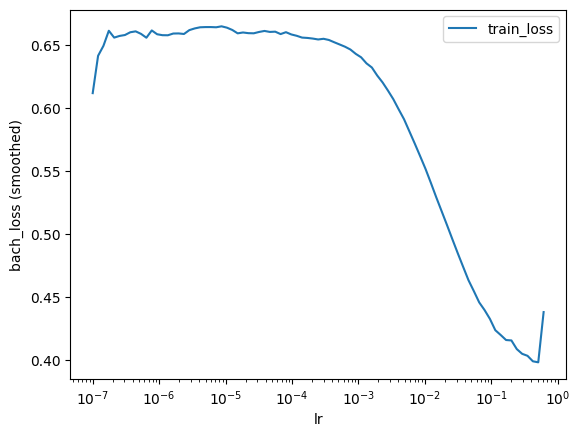

In [30]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [31]:
lrfinder.get_best_lr()

np.float64(0.050941380148164093)

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [32]:
model.optimizer.set_lr(0.01)

We include the EarlyStopping callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [33]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [34]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val.repeat(10).cat())

/media/datos/WORKSPACE/DOCTORADO/cdm_prototype/.venv/lib/python3.10/site-packages/torchtuples/tupletree.py:597: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.tuple_.apply(lambda x: x[index])


0:	[0s / 0s],		train_loss: 0.3265,	val_loss: 0.1590
1:	[0s / 0s],		train_loss: 0.2954,	val_loss: 0.1159
2:	[0s / 0s],		train_loss: 0.1337,	val_loss: 0.0883
3:	[0s / 0s],		train_loss: 0.0987,	val_loss: 0.0730
4:	[0s / 0s],		train_loss: 0.0789,	val_loss: 0.0669
5:	[0s / 0s],		train_loss: 0.0721,	val_loss: 0.0609
6:	[0s / 0s],		train_loss: 0.0722,	val_loss: 0.0678
7:	[0s / 0s],		train_loss: 0.0718,	val_loss: 0.0575
8:	[0s / 0s],		train_loss: 0.0778,	val_loss: 0.0542
9:	[0s / 0s],		train_loss: 0.0477,	val_loss: 0.0527
10:	[0s / 0s],		train_loss: 0.0591,	val_loss: 0.0467
11:	[0s / 0s],		train_loss: 0.0602,	val_loss: 0.0501
12:	[0s / 0s],		train_loss: 0.0496,	val_loss: 0.0493
13:	[0s / 0s],		train_loss: 0.0412,	val_loss: 0.0500
14:	[0s / 0s],		train_loss: 0.0444,	val_loss: 0.0528
15:	[0s / 0s],		train_loss: 0.0424,	val_loss: 0.0465
16:	[0s / 0s],		train_loss: 0.0414,	val_loss: 0.0587
17:	[0s / 0s],		train_loss: 0.0422,	val_loss: 0.0435
18:	[0s / 0s],		train_loss: 0.0409,	val_loss: 0.0447
19:

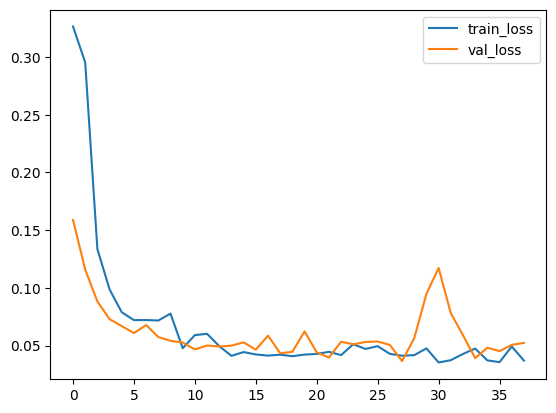

In [35]:
_ = log.plot()

In [36]:
model.partial_log_likelihood(*val).mean()

np.float32(-4.743315)

## Prediction
For evaluation we first need to obtain survival estimates for the test set. This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as Cox-Time is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

Note that for large datasets the sample argument can be used to estimate the baseline hazard on a subset.

In [37]:
labtrans.fit(*y_train)
baseline_hazards = model.compute_baseline_hazards()
# salvando las baselines hazards
joblib.dump(baseline_hazards, './cox_time_models/cox_time_baseline_hazards.joblib')

['./cox_time_models/cox_time_baseline_hazards.joblib']

In [38]:
surv = model.predict_surv_df(x_test)
surv

,0,1,2,3,4,5,6,7,8,9,...,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275
None,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
None,1.000000,9.999882e-01,1.000000,1.000000,9.999996e-01,1.000000,9.999741e-01,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,9.999994e-01,1.000000,1.000000,1.000000,1.000000,9.998923e-01,1.000000
None,1.000000,9.999194e-01,1.000000,1.000000,9.999968e-01,1.000000,9.997024e-01,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,9.999946e-01,1.000000,1.000000,1.000000,1.000000,9.990524e-01,1.000000
None,1.000000,9.997984e-01,1.000000,1.000000,9.999902e-01,1.000000,9.982851e-01,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,9.999854e-01,1.000000,1.000000,1.000000,1.000000,9.962768e-01,1.000000
None,1.000000,9.995137e-01,1.000000,1.000000,9.999695e-01,1.000000,9.877416e-01,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,9.999601e-01,1.000000,1.000000,1.000000,1.000000,9.811922e-01,1.000000
None,1.000000,9.984569e-01,1.000000,1.000000,9.999172e-01,1.000000,9.403008e-01,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,9.999130e-01,1.000000,1.000000,1.000000,1.000000,9.232746e-01,1.000000
None,1.000000,9.897745e-01,1.000000,1.000000,9.996670e-01,1.000000,6.600494e-01,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,9.997247e-01,1.000000,1.000000,1.000000,1.000000,6.329784e-01,1.000000
None,1.000000,9.305679e-01,1.000000,1.000000,9.982334e-01,1.000000,5.456902e-02,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,9.985376e-01,1.000000,1.000000,1.000000,1.000000,9.978563e-02,1.000000
None,1.000000,6.070226e-01,1.000000,1.000000,9.881232e-01,1.000000,1.704650e-09,1.000000,1.000000,1.000000,...,1.000000,0.999999,0.999999,9.892735e-01,1.000000,1.000000,1.000000,1.000000,4.396458e-05,1.000000
None,1.000000,4.470291e-02,1.000000,1.000000,9.210835e-01,1.000000,1.276282e-53,1.000000,1.000000,1.000000,...,1.000000,0.999998,0.999997,9.307335e-01,1.000000,1.000000,1.000000,1.000000,6.221333e-18,1.000000


(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]),
 [Text(0.0, 0, '0.0'),
  Text(2.5, 0, '2.5'),
  Text(5.0, 0, '5.0'),
  Text(7.5, 0, '7.5'),
  Text(10.0, 0, '10.0'),
  Text(12.5, 0, '12.5'),
  Text(15.0, 0, '15.0'),
  Text(17.5, 0, '17.5'),
  Text(20.0, 0, '20.0'),
  Text(22.5, 0, '22.5'),
  Text(25.0, 0, '25.0')])

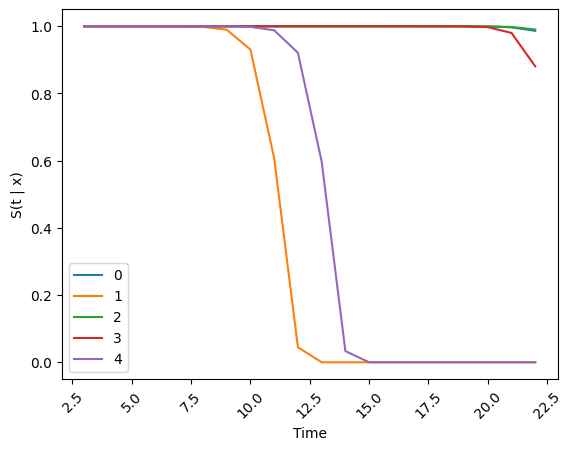

In [39]:
surv.index = np.sort(np.unique(df_train['time'].values))
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
plt.xlabel('Time')
plt.xticks(rotation=45)


## Evaluation 
We can use `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [40]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [41]:
ev.concordance_td()

/media/datos/WORKSPACE/DOCTORADO/cdm_prototype/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


0.9815459510319294

In [42]:
import joblib
joblib.dump(ev, './cox_time_models/cox_time_evaluation.joblib')

['./cox_time_models/cox_time_evaluation.joblib']

In [43]:
loaded_eval = joblib.load('./cox_time_models/cox_time_evaluation.joblib')
loaded_eval.concordance_td()

0.9815459510319294

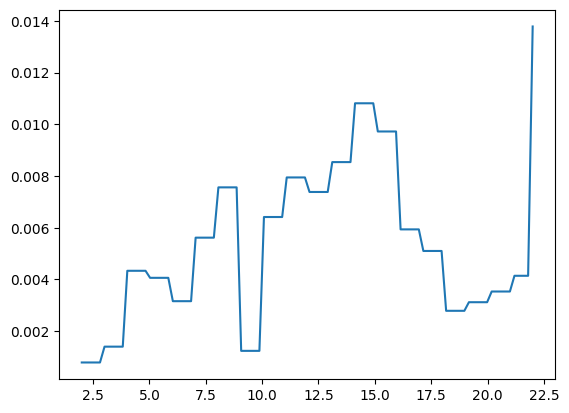

In [161]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [162]:
#parche por incompatibilidad
import scipy.integrate
if not hasattr(scipy.integrate, 'simps'):
    scipy.integrate.simps = scipy.integrate.simpson

In [163]:
ev.integrated_brier_score(time_grid)

np.float64(0.0052353917502911745)

In [164]:
ev.integrated_nbll(time_grid)

np.float64(0.017695771413685855)

### Salvando el modelo

In [165]:
# import joblib
# save_data = {
#     'model_state_dict': model.net.state_dict(),
#     'config': {
#         'in_features': in_features,
#         'num_nodes': num_nodes,
#         'batch_norm': batch_norm,
#         'dropout': dropout,
#         'labtrans': labtrans
#     },
#     'feature_names': df_train.columns.tolist()
# }
# torch.save(save_data, './cox_time_models/cox_time_model.pt')


In [166]:
model.save_model_weights('./cox_time_models/cox_time_model_weights.pt')
model.save_net('./cox_time_models/cox_time_net.pt')

In [174]:
joblib.dump(preprocessor, './cox_time_models/cox_time_preprocessor.joblib')
joblib.dump(labtrans, './cox_time_models/cox_time_labtrans.joblib')


['./cox_time_models/cox_time_baseline_hazards.joblib']

### Rehaciendo la arquitectura

In [175]:
loaded_net = torch.load('./cox_time_models/cox_time_net.pt', weights_only=False)
state_dict = torch.load('./cox_time_models/cox_time_model_weights.pt', weights_only=True)
net.load_state_dict(state_dict)
net.eval()

MLPVanillaCoxTime(
  (net): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=46, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (2): Linear(in_features=32, out_features=1, bias=False)
    )
  )
)

In [176]:
loaded_baseline_hazards = joblib.load('./cox_time_models/cox_time_baseline_hazards.joblib')
loaded_preprocessor = joblib.load('./cox_time_models/cox_time_preprocessor.joblib')
loaded_labtrans = joblib.load('./cox_time_models/cox_time_labtrans.joblib')

In [177]:

loaded_model = CoxTime(loaded_net, optimizer=tt.optim.Adam, labtrans=labtrans)
loaded_model.net.eval()


MLPVanillaCoxTime(
  (net): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=46, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (2): Linear(in_features=32, out_features=1, bias=False)
    )
  )
)

Cargar los nuevos datos

In [178]:
X_new = pd.read_csv('./../datasets/to_predict.csv')
X_new_scaled = loaded_preprocessor.transform(X_new).astype('float32')
x_tensor = torch.tensor(X_new_scaled, dtype=torch.float32)

Predecir

In [238]:
loaded_model.baseline_hazards_ = loaded_baseline_hazards
loaded_model.baseline_cumulative_hazards_ = loaded_model.compute_baseline_cumulative_hazards(
    set_hazards=True, 
    baseline_hazards_=loaded_baseline_hazards
)

In [252]:
times = loaded_baseline_hazards.index.values
surv = loaded_model.predict_surv_df(X_new_scaled)
surv.index = times
surv

,0,1,2
3.0,1.000000e+00,1.000000e+00,1.000000e+00
4.0,1.000000e+00,1.000000e+00,1.000000e+00
5.0,1.000000e+00,9.999999e-01,9.999998e-01
6.0,9.999999e-01,9.999998e-01,9.999997e-01
7.0,9.999999e-01,9.999996e-01,9.999993e-01
8.0,9.999987e-01,9.999964e-01,9.999921e-01
9.0,9.999882e-01,9.999695e-01,9.999276e-01
10.0,9.999443e-01,9.998417e-01,9.995893e-01
11.0,9.997112e-01,9.985986e-01,9.972800e-01
12.0,9.984623e-01,9.872633e-01,9.818536e-01


In [257]:
def median_times_simple(times, arr):
    mts = []
    for i in range(arr.shape[1]):
        idx = np.where(arr[:, i] <= 0.5)[0]
        mts.append(float(times[idx[0]]) if idx.size else np.inf)
    return pd.Series(mts, index=surv.columns, name='median_time_simple')

times = surv.index.values.astype(float)   # array de tiempos (ordenados)
arr = surv.values                          # shape (n_times, n_samples)
median_simple = median_times_simple(times, arr)
median_simple

0    16.0
1    14.0
2    14.0
Name: median_time_simple, dtype: float64

<Figure size 640x480 with 0 Axes>

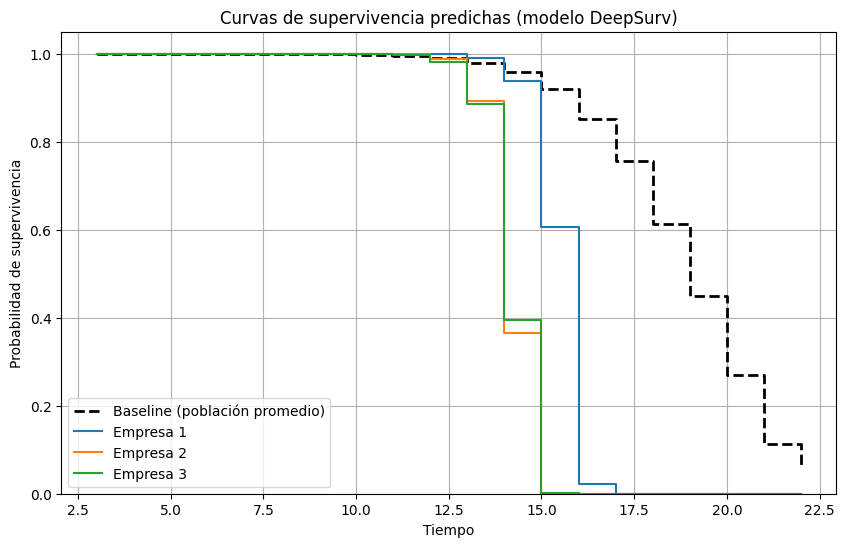

In [253]:
plt.figure()

# Obtener curvas de supervivencia para los nuevos pacientes
# surv = loaded_model.predict_surv_df(X_new_scaled)

# Obtener la baseline survival: S0(t) = exp(-H0(t))
baseline_survival = np.exp(-loaded_model.baseline_cumulative_hazards_)

# Graficar
plt.figure(figsize=(10, 6))

# Línea dashed para la baseline
plt.step(
    baseline_survival.index,
    baseline_survival.values,
    where='post',
    label='Baseline (población promedio)',
    color='black',
    linestyle='--',
    linewidth=2
)

# Graficar cada curva
for i in range(surv.shape[1]):  # surv.shape[1] = número de pacientes
    plt.step(surv.index, surv.iloc[:, i], where='post', label=f'Empresa {i+1}')

plt.ylabel('Probabilidad de supervivencia')
plt.xlabel('Tiempo')
plt.title('Curvas de supervivencia predichas (modelo DeepSurv)')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()